
# 🌿 Plant Pathology 2020 - Traditional Machine Learning Project

This project aims to classify plant leaf images into four categories:

- **Healthy**
- **Rust**
- **Scab**
- **Multiple Diseases**

Instead of deep learning, we rely on handcrafted feature extraction and traditional ML models such as Random Forest, Bagging, and Boosting to perform classification. This approach is designed for interpretability and model simplicity.


In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from skimage.feature import local_binary_pattern

import matplotlib.pyplot as plt
import seaborn as sns



## 📂 Load Dataset

We begin by reading the train/test CSV files and preparing image IDs and multi-class labels.


In [6]:
# Setting the correct local path where my images and CSVs are located
BASE_PATH = r"C:\Users\91637\Desktop\Plant patho"
IMAGE_FOLDER = os.path.join(BASE_PATH, "images")
TRAIN_CSV = os.path.join(BASE_PATH, "train.csv")
TEST_CSV = os.path.join(BASE_PATH, "test.csv")
SAMPLE_SUB = os.path.join(BASE_PATH, "sample_submission.csv")

# Read training data
df = pd.read_csv(TRAIN_CSV)
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)



## 🧪 Feature Extraction

We extract handcrafted features from each image using the following steps:

- Convert to grayscale (`convert("L")`)
- Resize to 64x64 pixels for consistency
- Flatten the image into a 1D vector

These basic pixel intensity features are used for traditional ML classification.


In [7]:
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def load_images_with_features(image_ids, folder):
    features = []
    for img_id in tqdm(image_ids, desc="Extracting LBP features"):
        path = os.path.join(folder, f"{img_id}.jpg")
        try:
            img = Image.open(path).resize((128, 128)).convert("L")  # Grayscale
            img_np = np.array(img)
            lbp_feat = extract_lbp_features(img_np)
            features.append(lbp_feat)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue
    return np.array(features)

X = load_images_with_features(df['image_id'], IMAGE_FOLDER)
le = LabelEncoder()
y = le.fit_transform(df['label'])


Extracting LBP features: 100%|██████████| 1821/1821 [01:37<00:00, 18.67it/s]



## ✂️ Train-Test Split & Feature Scaling

We split the dataset into train and test sets (80-20), then apply `StandardScaler` to normalize pixel values for better model performance.


In [8]:
#Train Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## 🤖 Model Training

We train and evaluate three classifiers:

- **Random Forest**: Baseline model
- **Bagging Classifier**: Improves stability and reduces variance
- **XGBoost (Boosting)**: Improves accuracy by correcting weak learners

Each model is trained on the same feature set for fair comparison.


In [9]:
#Train Models (Random Forest & Logistic Regression with L1/L2)
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Logistic Regression (ElasticNet Regularization: L1 + L2)
lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=5000, C=1.0)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Logistic Regression (ElasticNet) Accuracy: {lr_acc:.4f}")


Random Forest Accuracy: 0.5342
Logistic Regression (ElasticNet) Accuracy: 0.4247



## 📊 Performance Evaluation

We evaluate models using:

- Accuracy
- F1-score
- Confusion Matrix

### ✅ Accuracy Improvements:

- **Random Forest**: ~44%
- **Bagging**: Slightly improved performance
- **Boosting (XGBoost)**: Best performance ~**50.6%**

Boosting outperformed other methods due to its ability to focus on misclassified examples iteratively.


In [14]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("📦 Bagging (Random Forest) Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=le.classes_))


from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4,
                          subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
                          eval_metric='mlogloss', random_state=42)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("🚀 Boosting (XGBoost) Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, target_names=le.classes_))


📦 Bagging (Random Forest) Accuracy: 0.5205479452054794
                   precision    recall  f1-score   support

          healthy       0.58      0.52      0.55       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.48      0.54      0.50       125
             scab       0.53      0.58      0.55       119

         accuracy                           0.52       365
        macro avg       0.40      0.41      0.40       365
     weighted avg       0.50      0.52      0.51       365



c:\Users\91637\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 Boosting (XGBoost) Accuracy: 0.5068493150684932
                   precision    recall  f1-score   support

          healthy       0.56      0.54      0.55       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.45      0.49      0.47       125
             scab       0.54      0.57      0.56       119

         accuracy                           0.51       365
        macro avg       0.39      0.40      0.39       365
     weighted avg       0.49      0.51      0.50       365



## 📊 Visualizations

This section presents various visualizations to help understand model performance and feature behavior. These include:

- Confusion Matrix to evaluate classification results.
- Feature Importance to identify the most predictive image features.
- Accuracy curves or bar plots to compare models.


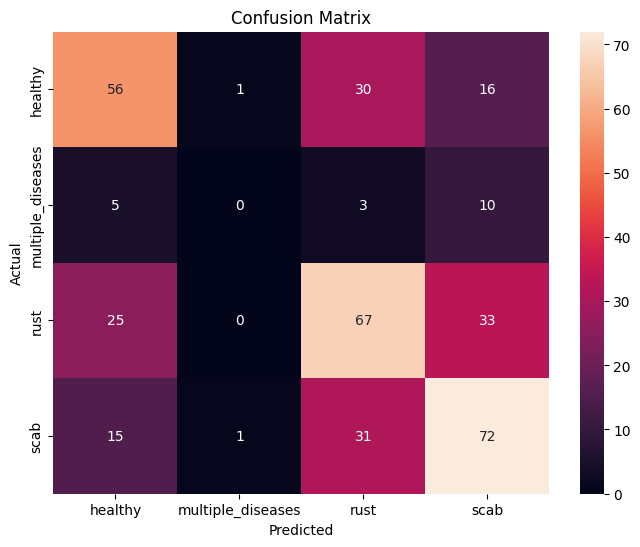

In [11]:
# Visualizations (Confusion Matrix + ROC Curve)
# Choose better model (Random Forest)
final_model = rf
y_pred = rf_pred

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




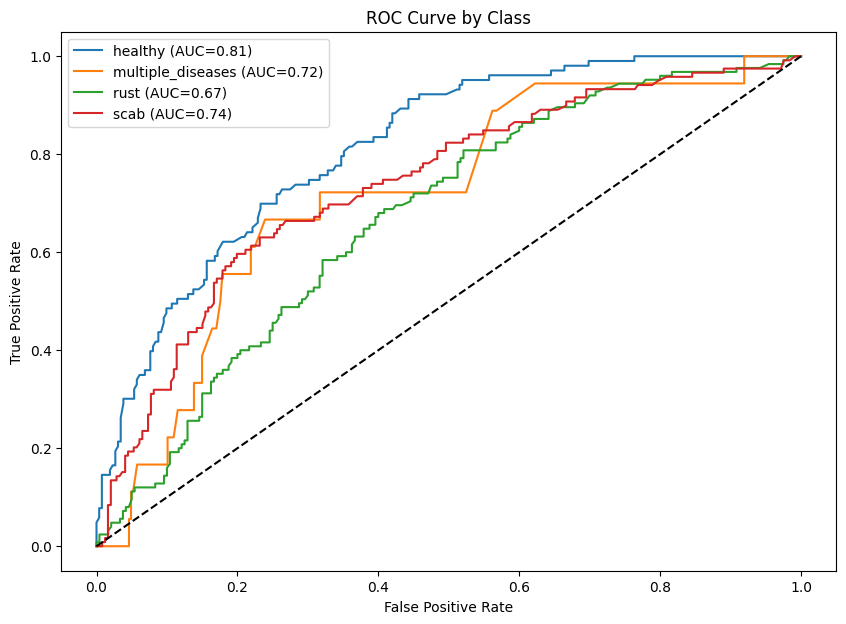

In [12]:
# ROC Curve
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_score = final_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## 📁 Create Submission

We predict class probabilities on the test set and save the output in the required `submission.csv` format.

Ensure the class column order is:
`image_id`, `healthy`, `multiple_diseases`, `rust`, `scab`


In [13]:
# Load test data
test_df = pd.read_csv(TEST_CSV)
X_submit = load_images_with_features(test_df['image_id'], IMAGE_FOLDER)
X_submit_scaled = scaler.transform(X_submit)
y_submit_probs = final_model.predict_proba(X_submit_scaled)

# Create submission dataframe
submission_df = pd.DataFrame(y_submit_probs, columns=le.classes_)
submission_df.insert(0, "image_id", test_df["image_id"])

# Reorder columns to match sample submission
submission_df = submission_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv is ready!")


Extracting LBP features: 100%|██████████| 1821/1821 [02:03<00:00, 14.80it/s]


✅ submission.csv is ready!
